In [2]:
from src.geojson import build_geojson_feature_collection
from src.cluster_stats import Stats
from src.dataframes.geohash_taxa_counts import GeohashTaxaCountsDataFrame
from src.render import plot_clusters
from src.geojson import build_geojson_feature_collection
import logging
from run import cluster
import polars as pl


In [3]:
# Inputs
input_file = "data-north-america-us-ca-mx.csv"
geohash_precision = 3
show_dendrogram = True
log_file = "log.txt"
output_file = "output.geojson"
num_clusters = 8
use_cache = False
plot = True

In [4]:
# set up logging
logging.basicConfig(filename=log_file, encoding="utf-8", level=logging.INFO)


In [5]:
geohash_taxa_counts_dataframe = GeohashTaxaCountsDataFrame.build(
    input_file, geohash_precision
)

In [6]:
geohash_taxa_counts_dataframe.df

geohash,kingdom,rank,name,count
str,enum,enum,str,u32
"""9em""","""Animalia""","""species""","""Ornidia obesa""",4
"""9em""","""Animalia""","""genus""","""Mydas""",3
"""9em""","""Animalia""","""genus""","""Ptecticus""",1
"""9em""","""Animalia""","""genus""","""Tabanus""",1
"""9em""","""Animalia""","""species""","""Toxomerus politus""",1
…,…,…,…,…
"""fkd""","""Animalia""","""order""","""Diptera""",1
"""fkd""","""Animalia""","""phylum""","""Arthropoda""",1
"""fkd""","""Animalia""","""family""","""Syrphidae""",1


/Users/coreyf/dev/frewsxcv/citizen-science-ecoregions-experiments/.venv/lib/python3.13/site-packages/sklearn/decomposition/_incremental_pca.py:376: RuntimeWarning: Mean of empty slice.
  self.noise_variance_ = explained_variance[self.n_components_ :].mean()
/Users/coreyf/dev/frewsxcv/citizen-science-ecoregions-experiments/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


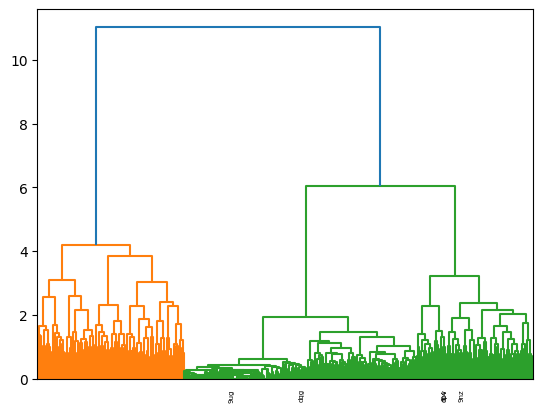

In [7]:

cluster_index = cluster.run(
    geohash_taxa_counts_dataframe,
    num_clusters,
    show_dendrogram,
    use_cache,
)

In [8]:
# Exclude the Aleutian Islands
cluster_index.df = cluster_index.df.filter(pl.col("geohash").str.starts_with("z").not_())

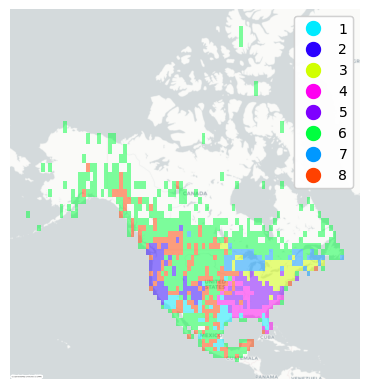

In [9]:
from src.dataframes.cluster_color import ClusterColorDataFrame

# Find the top averages of taxon
all_stats = Stats.build(geohash_taxa_counts_dataframe)

cluster_colors = ClusterColorDataFrame.from_clusters(cluster_index.cluster_ids())

feature_collection = build_geojson_feature_collection(
    cluster_index,
    cluster_colors,
)

# print_results(darwin_core_aggregations, all_stats, cluster_dataframe)

from run import write_geojson
write_geojson(feature_collection, output_file)

plot_clusters(feature_collection)

# write_geojson(feature_collection, args.output_file)

In [10]:
from src.html_output import build_html_output
from IPython.display import display, HTML

html = build_html_output(
    geohash_taxa_counts_dataframe,
    cluster_index,
    cluster_colors,
    all_stats,
)

display(HTML(html))


/Users/coreyf/dev/frewsxcv/citizen-science-ecoregions-experiments/.venv/lib/python3.13/site-packages/sklearn/decomposition/_incremental_pca.py:376: RuntimeWarning: Mean of empty slice.
  self.noise_variance_ = explained_variance[self.n_components_ :].mean()
/Users/coreyf/dev/frewsxcv/citizen-science-ecoregions-experiments/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/_w/vytm69g55mv9csjy701xgszr0000gn/T/ipykernel_54729/4174932746.py:26: UserWarning: The palette list has more values (10) than needed (8), which may not be intended.
  sns.scatterplot(


<Axes: >

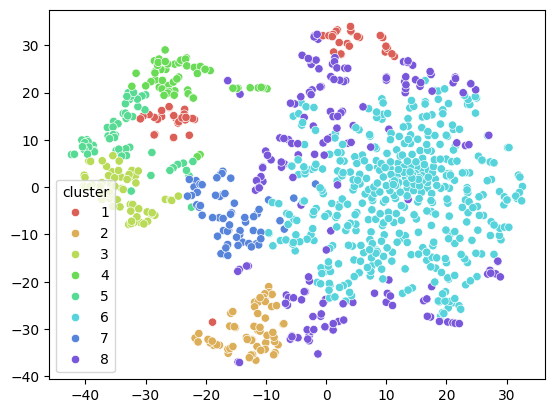

In [15]:
from scipy.spatial import distance
from src.cluster import build_condensed_distance_matrix

condensed_distance_matrix = build_condensed_distance_matrix(
    geohash_taxa_counts_dataframe,
    use_cache,
)

clusters = cluster_index.df.sort(by=pl.col("geohash"))["cluster"]

from sklearn.manifold import TSNE

square_distance_matrix = distance.squareform(condensed_distance_matrix)

tsne = TSNE(
    n_components=2,
    random_state=42,
    metric="precomputed",
    init="random",
)
X_tsne = tsne.fit_transform(square_distance_matrix)
tsne.kl_divergence_

import seaborn as sns

sns.scatterplot(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    hue=cluster_index.df["cluster"],
    palette=sns.color_palette("hls", 10),
    alpha=1,
)